<a href="https://colab.research.google.com/github/ProteinEngineer/Protein_codes/blob/main/Secondary_Structure_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import packages

In [ ]:
import numpy as np
import pandas as pd
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Masking, LSTM, TimeDistributed
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

Encode the Protein Data

In [ ]:
def get_list_from_excel(file_path, sheet_name, column):

    # Read Excel file into a DataFrame
    df = pd.read_excel(file_path, sheet_name=sheet_name)

    # Extract values from the specified column
    column_values = df[column].tolist()

    return column_values

# Example usage
file_path = "/PDB_info_output.xlsx"  # Replace with the actual path to your Excel file
sheet_name = "Protein info"  # Replace with the name of the sheet containing the data
  # Replace with the name of the column from which to extract the list

sequences = get_list_from_excel(file_path, sheet_name, column="Sequence")
structures = list(get_list_from_excel(file_path, sheet_name, column="Secondary Structure"))


def encode_sequence(seq):
    amino_acids = 'ACDEFGHIKLMNPQRSTVWXY'
    encoding = np.zeros((len(seq), len(amino_acids)))
    for i, aa in enumerate(seq):
        encoding[i, amino_acids.index(aa)] = 1
    return encoding

def encode_structure(struct):
    structure_map = {'H': 0, 'E': 1, 'C': 2, 'T': 3, '-': 4}
    for s in struct:
        if s != 'H' or s != 'E' and s != 'E' and s != 'T':
            return [structure_map['-']]
        else:
            return [structure_map[s]]

# Encode sequences
encoded_sequences = [encode_sequence(seq) for seq in sequences]
encoded_structures = [encode_structure(struct) for struct in structures]

# Find the maximum length
max_length = max(max(len(seq) for seq in sequences), max(len(struct) for struct in structures))

# Pad sequences and structures
padded_sequences = pad_sequences(encoded_sequences, maxlen=max_length, dtype='float32', padding='post')
padded_structures = pad_sequences(encoded_structures, maxlen=max_length, dtype='int32', padding='post')


Ratio Identifier

In [ ]:
from collections import Counter

def calculate_character_ratios(sequence):
    # Count occurrences of each character
    char_counts = Counter(sequence)

    # Total number of characters
    total_chars = len(sequence)

    # Calculate ratios
    char_ratios = {char: count / total_chars for char, count in char_counts.items()}

    return char_ratios

# Example usage

char_ratios = calculate_character_ratios(structures)

# Print the ratios
for char, ratio in char_ratios.items():
    print(f"{char}: {ratio:.2%}")

# Example output
print("Character Ratios:", char_ratios)

-HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH--HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH---HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH--HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH-: 0.18%
----HHHHHHHHSTT-EEEEEEEEEEEEESSS--HHHHHHHHHHHHHHHHHHHTTT---EEEEEEEETTEEEEEETTT--EEEEE-GGGEEEEEE-TT-TTEEEEEESSTT-EEEEEEEESS-SHHHHHHHHHHHHHHHHHHHHHHHHH-----HHHHHHHHSTT-EEEEEEEEEEEEESSS--HHHHHHHHHHHHHHHHHHHTTT---EEEEEEEETTEEEEEETTT--EEEEE-GGGEEEEEE-TT-TTEEEEEESSTT-EEEEEEEESS-SHHHHHHHHHHHHHHHHHHHHHHHH------HHHHHHHHSTT-EEEEEEEEEEEEESSS--HHHHHHHHHHHHHHHHHHHTTT---EEEEEEEETTEEEEEETTT--EEEEE-GGGEEEEEE-TT-TTEEEEEESSTT-EEEEEEEESS-SHHHHHHHHHHHHHHHHHHHHHHHHT---EE-TT----EE-TT----EE-TT--: 0.18%
--HHHHHHHHSTT-EEEEEEEEEEEE-S-S--HHHHHHHHHHHHHHHHHHGGGT---EEEEEEEETTEEEEEETTT--EEEEE-GGGEEEEEEETTEEEEEEEEESSTT--EEEEEEESS-SHHHHHHHHHHHHHHHHHHHHHHHTGGG--HHHHHHHHHHSTT-EEEEEEEEEEEE-SSS--HHHHHHHHHHHHHHHHHHHTTT---EEEEEEEETTEEEEEETTT--EEEEE-GGGEEEEEEETTEEEEEEEEEEETTEEEEEEEEESS-SHHHHHHHHH

In [ ]:
# Pad sequences
X = pad_sequences(encoded_sequences, maxlen=max_length, dtype='float32', padding='post')


# Encode structures to numerical form
num_classes = len({'H': 0, 'E': 1, 'C': 2, 'T': 3, '-': 4})
y = to_categorical(padded_structures, num_classes=num_classes)

print("Encoded Sequences Shape: ", X.shape)  # (number_of_samples, sequence_length, number_of_amino_acids)
print("Encoded Structures Shape: ", y.shape)  # (number_of_samples, sequence_length, number_of_classes)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Build the model
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(max_length, len('ACDEFGHIKLMNPQRSTVWXY'))))
model.add(LSTM(64, return_sequences=True))
model.add(TimeDistributed(Dense(num_classes, activation='softmax')))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32, callbacks=[early_stopping])


Encoded Sequences Shape:  (549, 5420, 21)
Encoded Structures Shape:  (549, 5420, 5)
Epoch 1/5
14/14 [==============================] - 62s 4s/step - loss: 1.3178 - accuracy: 0.8764 - val_loss: 0.4093 - val_accuracy: 0.9992
Epoch 2/5
14/14 [==============================] - 58s 4s/step - loss: 0.0838 - accuracy: 0.9990 - val_loss: 0.0135 - val_accuracy: 0.9992
Epoch 3/5
14/14 [==============================] - 54s 4s/step - loss: 0.0111 - accuracy: 0.9990 - val_loss: 0.0078 - val_accuracy: 0.9992
Epoch 4/5
14/14 [==============================] - 58s 4s/step - loss: 0.0082 - accuracy: 0.9990 - val_loss: 0.0067 - val_accuracy: 0.9992
Epoch 5/5
14/14 [==============================] - 54s 4s/step - loss: 0.0075 - accuracy: 0.9990 - val_loss: 0.0063 - val_accuracy: 0.9992


Plot the training history of the ML

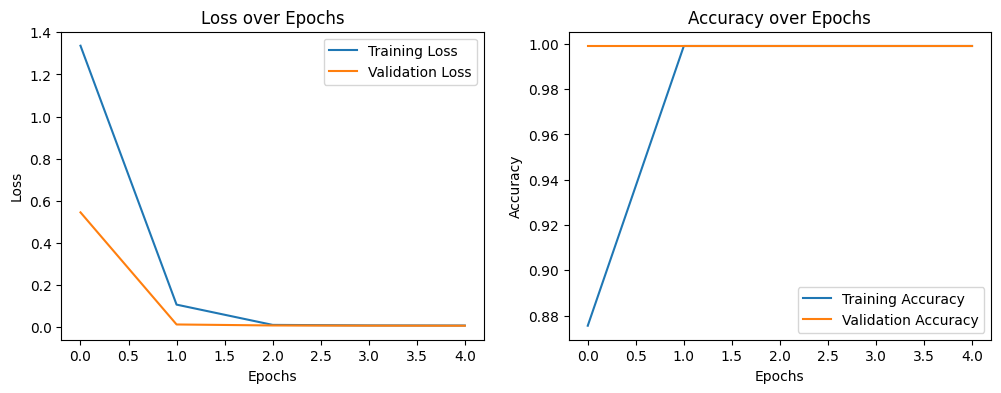

4/4 [==============================] - 3s 740ms/step - loss: 0.0062 - accuracy: 0.9992
Validation Loss: 0.006186832673847675
Validation Accuracy: 0.9991613626480103


In [ ]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')

plt.show()

# Evaluate the model on the validation set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

Save the model

In [ ]:
# Save the model to a file
model.save('secondary_structure_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Load model

In [ ]:
import tensorflow as tf
from tensorflow import keras
# Load the model from the file
model = keras.models.load_model('secondary_structure_model.h5')

OSError: No file or directory found at secondary_structure_model.h5

Input

In [ ]:
import numpy as np

# New data for prediction
X_new = input()  # Example new data
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(len(X_new), 1)),])
sequence = tuple(encode_sequence(X_new))
#sequence = np.expand_dims(sequence, axis=1)
sequence =  sequence.reshape((1, len(sequence), 21))
# Make predictions
def predict_secondary_structure(sequence, model):
    prediction = model.predict(sequence)
    prediction = tuple(prediction)
    print(str(prediction))
    # Decoder for secondary structure
    decoder = {0: 'H', 1: 'E', 2: 'C', 3 : 'T', 4 : '-'}
    predicted_structure = ''.join([decoder[p] for p in prediction])

    return predicted_structure

# Example usage
predicted_structure = predict_secondary_structure(sequence, model)
print(f"Predicted secondary structure: {predicted_structure}")

MKMKTHRGSAKRKKTGSGKKRSHAYTSHANKSKKRKRKSAVVSAGDKRKMANK


NameError: name 'keras' is not defined